____
<div style="text-align: center;">
    <img src="Shariflogo.png" alt="Alt Text" width="200">
</div>
<div dir=ltr align=center>
<font color=29A719 size=7>
    Massive Data Analaysis Project <br>
<font color=BFE8B9 size=5>
    Electrical Engineering Department <br>
    Fall 2024 <br>
    Arman Yazdani 400102255 <br>
    
____

# Spark initialization

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession as ss

spark = ss.builder.appName("MDA2024-Project").master("local[*]").config("spark.executor.memory", "2g")\
    .config("spark.driver.memory", "2g").config("spark.hadoop.native.lib", "false")\
    .config("spark.sql.files.ignoreCorruptFiles", "true") \
    .config("spark.sql.files.ignoreMissingFiles", "true") \
    .config("spark.hadoop.io.nativeio.NativeIO", "false") \
    .getOrCreate()
sc=spark.sparkContext

sc

<SparkContext master=local[*] appName=MDA2024-Project>

# 1

## Load

In [ ]:
import json
df = spark.read.json("twitter_data.jsonl")

## Interaction Graph

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, lit

df.cache()

# --- Build the interaction edges ---
# Replies: a tweet that is a reply creates an edge from the tweeting user to the replied user.
replies = df.filter(col("in_reply_to_screen_name").isNotNull()) \
    .select(col("user.screen_name").alias("src"),
            col("in_reply_to_screen_name").alias("dst"),
            lit("reply").alias("interaction"))

# Retweets: if a tweet has a non-null retweeted_status.
retweets = df.filter(col("retweeted_status").isNotNull()) \
    .select(col("user.screen_name").alias("src"),
            col("retweeted_status.user.screen_name").alias("dst"),
            lit("retweet").alias("interaction"))

# Quotes: if a tweet has a non-null quoted_status.
quotes = df.filter(col("quoted_status").isNotNull()) \
    .select(col("user.screen_name").alias("src"),
            col("quoted_status.user.screen_name").alias("dst"),
            lit("quote").alias("interaction"))

# Mentions: explode the array of user mentions.
mentions = df.select(col("user.screen_name").alias("src"),
                     explode("entities.user_mentions").alias("mention")) \
    .select("src", col("mention.screen_name").alias("dst")) \
    .withColumn("interaction", lit("mention"))

# Combine all interactions into one DataFrame.
edges = replies.union(retweets).union(quotes).union(mentions).dropDuplicates()


## User Scores

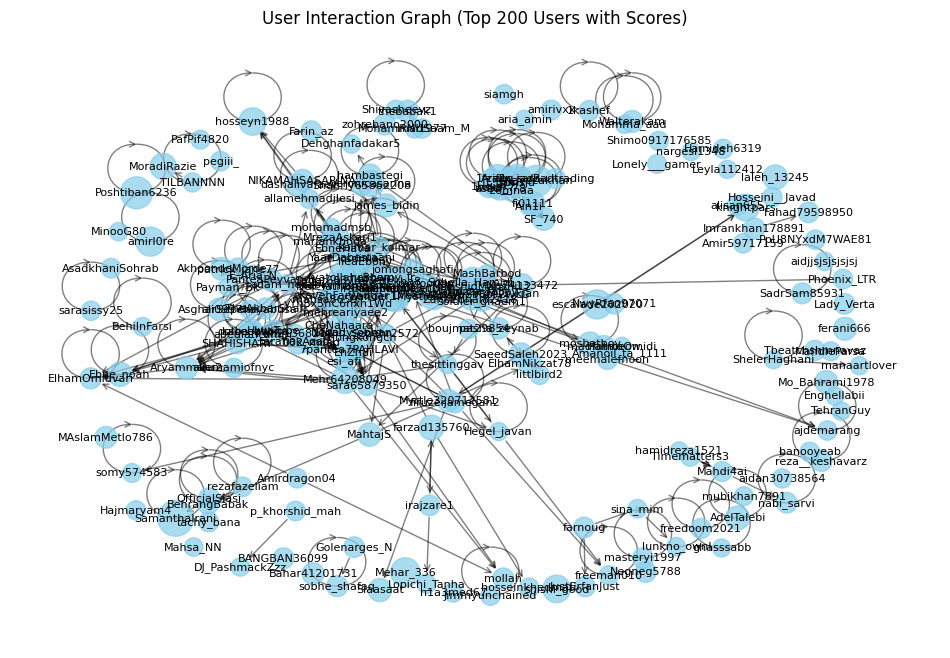

In [ ]:
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import when

# --- Assign weights to interaction types ---
edges_weighted = edges.withColumn("weight",
    when(col("interaction") == "reply", 2.0)
    .when(col("interaction") == "retweet", 1.5)
    .when(col("interaction") == "quote", 1.0)
    .otherwise(1.0)
)
# Compute a score for each user (based on outgoing interactions).
user_scores = edges_weighted.groupBy("src").agg(_sum("weight").alias("score")) \
    .withColumnRenamed("src", "user")

# For visualization, choose a subset of nodes (e.g., top 200 users by score).
top_users_df = user_scores.orderBy(col("score").desc()).limit(200)
top_users = [row.user for row in top_users_df.select("user").collect()]

# Also, filter edges that connect these top users.
viz_edges = edges_weighted.filter((col("src").isin(top_users)) & (col("dst").isin(top_users))) \
    .select("src", "dst", "weight").collect()

# --- Build and visualize the graph using NetworkX ---
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes with the score as an attribute.
for row in top_users_df.collect():
    G.add_node(row.user, score=row.score)

# Add edges with the weight attribute.
for row in viz_edges:
    G.add_edge(row.src, row.dst, weight=row.weight)

# Draw the graph.
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # for reproducible layout
# Scale node sizes (multiply score by a factor for visibility).
node_sizes = [G.nodes[node]['score'] * 5 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7, node_color="skyblue")
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("User Interaction Graph (Top 200 Users with Scores)")
plt.axis("off")
plt.show()


## Pixie

In [ ]:
import random

def pixie_networkx_weighted(G, seed, num_walks=200, walk_length=3):
    """
    Perform Pixie-style random walks on a local NetworkX graph (G) starting from 'seed',
    where each step is chosen with probability proportional to the edge weight.

    Parameters:
      - G: a NetworkX DiGraph representing the user interaction graph.
           Each edge should have a 'weight' attribute.
      - seed: the starting node (user) for the random walks.
      - num_walks: the number of independent random walks to simulate.
      - walk_length: the number of steps in each walk.

    Returns:
      - A list of tuples (user, visit_count) sorted in descending order by visit_count,
        excluding the seed itself.
    """
    visit_counts = {}  # Dictionary to count visits per node

    for _ in range(num_walks):
        current = seed
        for _ in range(walk_length):
            neighbors = list(G.successors(current))
            if not neighbors:
                # If no outgoing edge, break out of the walk.
                break
            # Retrieve the edge weight for each neighbor (default to 1.0 if not present)
            weights = [G[current][nbr].get('weight', 1.0) for nbr in neighbors]
            # Choose a neighbor using weights as probabilities.
            current = random.choices(neighbors, weights=weights, k=1)[0]
        # Exclude the seed from being counted.
        if current != seed:
            visit_counts[current] = visit_counts.get(current, 0) + 1

    # Sort the nodes by the number of visits (similarity score) in descending order.
    sorted_visits = sorted(visit_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_visits

# Example usage:
# Assume G is a pre-built NetworkX DiGraph (from the previous sampling and visualization steps),
# and that edges in G have a 'weight' attribute.
for seed_user in list(G.nodes):
    similar_users = pixie_networkx_weighted(G, seed=seed_user, num_walks=200, walk_length=3)

    for user, visits in similar_users:
        if similar_users and visits != 200:
            print(f"Pixie Similarity Results (based on random walks starting from '{seed_user}'):")
            print(f"User: {user}, Visits: {visits}")

Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: adam_hesabi, Visits: 19
Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: Ivar_lathbrug2, Visits: 15
Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: _Mahdiyar313, Visits: 14
Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: pizza_facey, Visits: 13
Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: Veronicasarina, Visits: 12
Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: iranianpappiii3, Visits: 10
Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: Aryammehr2, Visits: 10
Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: hambastegi, Visits: 9
Pixie Similarity Results (based on random walks starting from 'Armanjasoor'):
User: CheNahaara, Visits: 8
Pixie Similarity Resul

# 4

## Load

In [ ]:
import json
df = spark.read.json("twitter_data.jsonl")

## Spam Detection

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# 1. Enhanced TrustRank with Normalization
DAMPING_FACTOR = 0.85  # Controls trust propagation
MAX_ITERATIONS = 10    # Reduced for stability
TRUST_DECAY = 0.95     # Per-iteration decay

# Build Link Graph from User Mentions
mention_edges = df.select(
    F.col("user.id").alias("source_user"),
    F.explode("entities.user_mentions").alias("mention")
).select(
    "source_user",
    F.col("mention.id").alias("target_user")
)
# Seed selection with engagement filter
seed_users = df.select("user.*").filter(
    (F.col("verified") == True) &
    (F.col("followers_count") > 10000) &
    (F.col("friends_count")/F.col("followers_count") < 0.1) &
    (F.col("engagement_rate_v2") > 0.5)
).select(
    F.col("id").alias("user_id")
).distinct()

# Initialize trust scores with decay
trust_rank = seed_users.withColumn("trust_score", F.lit(1.0))

for i in range(MAX_ITERATIONS):
    # Calculate out-degree for normalization
    out_degree = mention_edges.groupBy("source_user_id").agg(
        F.count("*").alias("out_links")
    )

    # Propagate trust with damping and normalization
    new_trust = mention_edges.join(
        trust_rank.withColumnRenamed('user_id', 'source_user_id'), "source_user_id"
    ).join(
        out_degree, "source_user_id"
    ).withColumn(
        "propagated_trust",
        F.col("trust_score") * (DAMPING_FACTOR/(F.col("out_links") + 1e-5))
    ).groupBy("target_user_id").agg(
        F.sum("propagated_trust").alias("new_trust")
    )

    # Update trust scores with decay and base seed preservation
    trust_rank = new_trust.join(
        seed_users.alias("seeds"),
        F.col("target_user_id") == F.col("seeds.user_id"),
        "outer"
    ).select(
        # Merge IDs with explicit aliases
        F.coalesce("target_user_id", "seeds.user_id").alias("user_id"),

        # Trust calculation with clear seed reference
        (
            F.coalesce("new_trust", F.lit(0.0)) * (TRUST_DECAY**i) +
            F.when(F.col("seeds.user_id").isNotNull(), 1-TRUST_DECAY**i)
            .otherwise(0)
        ).alias("trust_score")
    ).alias("trust_rank")



In [ ]:

# Normalize final trust scores
window = Window.orderBy(F.desc("trust_score"))
trust_rank = trust_rank.withColumn(
    "trust_score",
    F.col("trust_score")/F.sum("trust_score").over(Window.partitionBy())
)

# Full revised spam features block
spam_features = df.select(
    "id",
    (1 - F.coalesce("engagement_rate_v2", F.lit(0.0))).alias("engagement_risk"),
    (F.size("entities.urls")/5.0).alias("url_density"),  # [0-1] scaled
    (F.size("entities.hashtags")/10.0).alias("hashtag_density"),
    (F.col("nlp.sentiment") == "negative").cast("float").alias("negative_sentiment"),
    F.least(  # Revised retweet ratio
        F.col("retweet_count") / (F.coalesce(F.col("user.followers_count"), F.lit(1)) + 1),
        F.lit(5.0)
    ).alias("retweet_ratio")
).fillna(0.0, subset=["retweet_ratio"])  # Extra safety

# Sigmoid-style scoring with interaction terms
spam_mass = spam_features.withColumn(
    "spam_score",
    F.exp(-(
        2.5 * F.col("engagement_risk") +
        1.8 * F.col("url_density") +
        1.2 * F.col("hashtag_density") +
        0.5 * F.col("negative_sentiment") +
        1.0 * F.col("retweet_ratio") * F.col("url_density")
    ))
)

# 3. Adaptive Threshold Combination
final_scores = df.join(
    trust_rank,
    df.user.id == trust_rank.user_id,
    "left"
).join(
    spam_mass,
    "id",
    "left"
).withColumn(
    "spam_value",
    (0.6 * (1 - F.coalesce("trust_score", F.lit(0.3))) +
     0.4 * F.col("spam_score"))
)

# Dynamic threshold based on distribution
quantiles = final_scores.approxQuantile("spam_value", [0.75], 0.05)
dynamic_threshold = quantiles[0] * 1.5  # Adjust multiplier based on precision needs

spam_tweets = final_scores.filter(
    F.col("spam_value") > dynamic_threshold
).select(
    "id",
    "text",
    "spam_value",
    F.col("user.id").alias("user_id")
)

# 4. Post-filtering to clean trusted users
window_spec = Window.partitionBy("user.id").orderBy(F.desc("spam_value"))

clean_spam = (
    final_scores
    .filter(F.col("spam_value") > dynamic_threshold)
    .withColumn("user_trust_avg", F.avg("trust_score").over(Window.partitionBy("user.id")))
    .withColumn("post_rank", F.rank().over(window_spec))
    .select(
        "id",
        "text",
        "spam_value",
        F.col("user.id").alias("user_id"),
        "user_trust_avg"
    )
    .filter(
        (F.col("user_trust_avg") < 0.4) |
        (F.col("post_rank") < 5)
    )
)
clean_spam.select('text','spam_value').show()


+--------------------+------------------+
|                text|        spam_value|
+--------------------+------------------+
|دوستانی که ریموت ...|2.3017633100286403|
|به عنوان پزشک، دا...| 6.385299525535547|
|بنا به نظر #وزیر_...|11920.432214382174|
|ظاهراً سازمان اطل...| 3126.438134169463|
|اگر صحبت‌های آ.عج...|  797.080963052442|
|در پرونده مرحوم #...| 541.3463808223413|
|تصویر مخالفان جنگ...|410.10434789192743|
|من هم از خ.‌معصوم...| 48.59558573861245|
|در برابر اقدامات ...|   32.474565001447|
|#پرویز_ثابتی ادعا...|24.931251024162695|
|نقض دهها حکم اعدا...| 17.96457602969495|
|ماهها قبل در ۹ خر...|16.465645399099685|
|رییس #دانشگاه_شری...|14.681581998197373|
|شورای نگهبان غیر ...| 9.769977213616965|
|ایشان سالها وزیر ...| 9.685501727702576|
|کجای فقه و شریعت،...| 9.353116697197017|
|توقیف خودروها بدو...| 5.498738584024464|
|چند پرسش:\n۱. اعض...|3.9983659175745667|
|سید احمد خاتمی: «...|2.9754483020493256|
|ماده ۴۰ قانون مجا...|1.9784718493124873|
+--------------------+------------

# 7

## Batching

In [2]:
import os
import math
import pandas as pd
from pyspark.sql.types import StructType, StructField, LongType, StringType, ArrayType
from pyspark.sql.functions import explode, col

# Define a minimal schema for the JSON data.
schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("nlp", StructType([
         StructField("sentiment", StringType(), True)
    ]), True),
    StructField("entities", StructType([
         StructField("hashtags", ArrayType(
             StructType([
                StructField("text", StringType(), True)
             ])
         ), True)
    ]), True)
])

# Read the JSONL file as a static DataFrame.
df = spark.read.schema(schema).json("/content/twitter_sample.jsonl")

# Flatten the data by exploding the hashtags array.
# This produces one row per hashtag.
flat_df = df.withColumn("hashtag", explode(col("entities.hashtags.text"))) \
            .select("timestamp", col("nlp.sentiment").alias("sentiment"), "hashtag")

# Collect the flattened DataFrame (small datasets are OK).
rows = flat_df.collect()

# Define batch size and output directory.
batch_size = 10
output_dir = "streaming_csv"
os.makedirs(output_dir, exist_ok=True)

# Compute the number of batches and write each batch as a CSV file.
num_batches = math.ceil(len(rows) / batch_size)
for i in range(num_batches):
    batch_rows = rows[i * batch_size:(i + 1) * batch_size]
    # Convert each Row to a dictionary.
    batch_dicts = [row.asDict() for row in batch_rows]
    batch_pd_df = pd.DataFrame(batch_dicts)
    csv_file = os.path.join(output_dir, f"batch_{i}.csv")
    batch_pd_df.to_csv(csv_file, index=False)
    print(f"Wrote {csv_file}")


Wrote streaming_csv/batch_0.csv
Wrote streaming_csv/batch_1.csv
Wrote streaming_csv/batch_2.csv
Wrote streaming_csv/batch_3.csv
Wrote streaming_csv/batch_4.csv
Wrote streaming_csv/batch_5.csv
Wrote streaming_csv/batch_6.csv
Wrote streaming_csv/batch_7.csv
Wrote streaming_csv/batch_8.csv
Wrote streaming_csv/batch_9.csv
Wrote streaming_csv/batch_10.csv
Wrote streaming_csv/batch_11.csv
Wrote streaming_csv/batch_12.csv
Wrote streaming_csv/batch_13.csv
Wrote streaming_csv/batch_14.csv
Wrote streaming_csv/batch_15.csv
Wrote streaming_csv/batch_16.csv
Wrote streaming_csv/batch_17.csv
Wrote streaming_csv/batch_18.csv
Wrote streaming_csv/batch_19.csv
Wrote streaming_csv/batch_20.csv
Wrote streaming_csv/batch_21.csv
Wrote streaming_csv/batch_22.csv
Wrote streaming_csv/batch_23.csv
Wrote streaming_csv/batch_24.csv
Wrote streaming_csv/batch_25.csv
Wrote streaming_csv/batch_26.csv
Wrote streaming_csv/batch_27.csv
Wrote streaming_csv/batch_28.csv
Wrote streaming_csv/batch_29.csv
Wrote streaming_csv/

## Stream Data analysis

In [5]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, LongType, StringType
from pyspark.sql.functions import to_timestamp, window, when, col, count, avg

# Define the schema for the CSV files.
# The CSV files are assumed to have columns: timestamp, sentiment, hashtag.
csv_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("sentiment", StringType(), True),
    StructField("hashtag", StringType(), True)
])

# Read the CSV files as a streaming source.
# The option "maxFilesPerTrigger" simulates a new batch arriving by processing one file per trigger.
csv_stream = spark.readStream \
    .schema(csv_schema) \
    .option("maxFilesPerTrigger", 1) \
    .csv("/content/streaming_csv")

# Prepare the DataFrame by converting the timestamp column to an event time
# and mapping the sentiment string to a numeric value (-1, 1, or 0).
tweets = csv_stream.withColumn("event_time", to_timestamp(col("timestamp"))) \
                   .withColumn("sentiment_value",
                               when(col("sentiment") == "Neg", -1)
                               .when(col("sentiment") == "Pos", 1)
                               .otherwise(0))

# **Query 1: Hashtag counts over a 2-second window.**
# Modified hashtag_counts query
hashtag_counts = tweets.withWatermark("event_time", "2 seconds") \
    .groupBy(
        window(col("event_time"), "2 seconds"),
        col("hashtag")
    ).agg(count("*").alias("hashtag_count"))

# Change output mode
query_counts = hashtag_counts.writeStream \
    .outputMode("update") \
    .format("memory") \
    .queryName("hashtag_counts_table") \
    .option("truncate", False) \
    .trigger(processingTime="1 second") \
    .start()


# **Query 2: Average sentiment per hashtag.**
hashtag_sentiment_avg = tweets.groupBy("hashtag") \
    .agg(avg("sentiment_value").alias("avg_sentiment"))

query_sentiment = hashtag_sentiment_avg.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("sentiment_table") \
    .option("truncate", False) \
    .trigger(processingTime="1 second") \
    .start()

# Instead of using .awaitTermination(), poll for a fixed amount of time.
for i in range(30):  # Let the stream run for 30 seconds.
    if not (query_counts.isActive and query_sentiment.isActive):
        break
    time.sleep(1)

# Stop the streaming queries gracefully.
spark.sql("SELECT * FROM hashtag_counts_table").show()
spark.sql("SELECT * FROM sentiment_table").show()


+--------------------+--------------------+-------------+
|              window|             hashtag|hashtag_count|
+--------------------+--------------------+-------------+
|{2023-12-01 06:14...|         پرستو_معینی|            1|
|{2023-11-22 11:18...|        دلیران_میدان|            1|
|{2023-12-01 06:14...|          زهرا_صفایی|            1|
|{2023-11-10 07:10...|         درمان_سرطان|            1|
|{2023-11-10 07:10...|       سرطان_پروستات|            1|
|{2023-11-10 07:10...|          رادیوتراپی|            1|
|{2023-11-10 07:10...|               سرطان|            1|
|{2023-11-10 07:10...|    متخصص_انکولوژیست|            1|
|{2023-11-22 11:18...|           بسیج_مردم|            1|
|{2023-11-10 07:10...|          انکولوژیست|            1|
|{2023-12-01 06:14...|     محمدمسعود_معینی|            1|
|{2023-11-13 10:14...|           میدان_دار|            1|
|{2023-12-01 06:14...|            حقوق_بشر|            1|
|{2023-12-01 06:14...|     اعتراضات_سراسرى|            1|
|{2023-12-01 0